<a href="https://colab.research.google.com/github/JulienPeignon/MonteCarlo/blob/main/unbiased_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Simulation and Monte Carlo Methods (ENSAE)**</center> 

For our Monte Carlo class , we reproduce the simulation experiments of the paper ["*On Multilevel Monte Carlo Unbiased Gradient Estimation for Deep Latent Variable Models*"](https://proceedings.mlr.press/v130/shi21d.html) written by Yuyang Shi and Rob Cornish in 2021. We limit ourselves to the Linear Gaussian framework from [Rainforth et al. (2019)](http://proceedings.mlr.press/v80/rainforth18b/rainforth18b.pdf) and [Tucker et al. (2018)](https://arxiv.org/pdf/1810.04152.pdf) to quantify the bias and the variance of the computed estimators.



---



---
 

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

# **1) GENERATION DES DONNEES**

On tire un échantillon i.i.d. de $z_i$ de densité $q_{\phi}(.|x)$. Dans notre application on définit $q_{\phi}(.|x)$ comme une loi normale multivariée de moyenne nulle et de matrice de variance-covariance $2/3*I$. La distribution de notre encodeur est  donc $q_\phi(z\mid x)=\mathcal{N}\left(z\mid x,\frac{2}{3} I\right)$. Nous ne considérons pas dans notre application de perturbations additionnelles sur cette distribution. Ainsi, ${\phi} = (I,0)$ mais on construit les fonctions Python de manière la plus générale possible avec ${\phi} = (A,b)$.

On a également $p_{\boldsymbol{\theta}}(\boldsymbol{x})=\mathcal{N}(\boldsymbol{x} \mid \boldsymbol{\theta}, 2 \boldsymbol{I})$

In [3]:
def generation_z(A,b,K,covar,x):
    z_O = []
    z_E = []
    for i in range(int(2**K)):
        z_O.append(np.random.multivariate_normal(np.dot(A,x)+b, (2/3)*covar))
        z_E.append(np.random.multivariate_normal(np.dot(A,x)+b, (2/3)*covar))
    z = z_O.copy()
    z.extend(z_E)
    return z, z_O, z_E

In [4]:
def generation_q_p(A,b,K,mean_vect,covar,x,z,z_O,z_E):
    q, p, q_O, p_O, q_E, p_E = [],[],[],[],[],[]
    for i in range(int(2**(K))):
        q_O.append(multivariate_normal.pdf(z_O[i], mean=np.dot(A,x)+b, cov=(2/3)*covar))
        q_E.append(multivariate_normal.pdf(z_E[i], mean=np.dot(A,x)+b, cov=(2/3)*covar))
        p_O.append(multivariate_normal.pdf(z_O[i], mean=mean_vect, cov=covar)*multivariate_normal.pdf(x, mean=z_O[i], cov=covar))
        p_E.append(multivariate_normal.pdf(z_E[i], mean=mean_vect, cov=covar)*multivariate_normal.pdf(x, mean=z_E[i], cov=covar))
    q,p = q_O.copy(),p_O.copy()
    q.extend(q_E)
    p.extend(p_E)
    return q, p, q_O, p_O, q_E, p_E

# **2) FONCTION POUR SS**

In [5]:
def estimator_ML_SS(n_sim, x, mean_vect, covar, A, b, r):

    ss = []
    for i in range(n_sim):

        # generate our data following our true parameter theta_true and our observations at mean_vect
        K = np.random.geometric(r)

        z, z_O, z_E = generation_z(A,b,K,covar,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K,mean_vect,covar,x,z,z_O,z_E)

        # compute the proposal "posterior"
        w = [p[i]/q[i] for i in range(len(p))] 
        w_O = [p_O[i]/q_O[i] for i in range(len(p_O))] 
        w_E = [p_E[i]/q_E[i] for i in range(len(p_E))] 
            
        # compute I0
        I0 = np.mean(np.log(w))

        # compute Lo and Le
        lO = np.log(np.mean(w_O))
        lE = np.log(np.mean(w_E))  

        # compute L_OE
        L_OE = np.log(np.mean(w))
    
        # compute delta_K
        delta_K = L_OE - 0.5*(lO + lE)
    
        # compute the final estimator
        proba = r*(1-r)**(int(K)-1)
        ML_SS = I0 + delta_K/proba
        
        ss.append(ML_SS)

    
    mean_value = np.mean(ss)
    std_error_value = np.std(ss) / np.sqrt(len(ss))

    return mean_value #the mean value of the log likelihood 


In [6]:
def estimate_theta(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')
            c+=1
            
            Y.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [7]:
def calcul_likelihood(x,theta):
  cste = (2*np.pi)**(-len(x)/2)*1/(np.sqrt(np.linalg.det(2*np.identity(20))))
  somme = 0
  for i in range(len(x)):
    somme += (x[i] - theta)**2
  return cste*np.exp(-somme/4)

In [ ]:
def gaussian_experience(debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)
  
  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  theta_estimator, X, Y = estimate_theta(x,debut,fin,n_sim,n_interval)
  #print("theta estimé =",theta_estimator)
  plt.scatter(X,Y,color = 'blue',label = 'log-likelihood estimée')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'log-likelihood théorique')
  plt.legend()

  biais_median = np.median([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  biais_mean = np.mean([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  print("le biais squared médian de la log likelihood vaut",biais_median )
  print("le biais squared moyen de la log likelihood vaut",biais_mean )


true value of theta 0.8347239491576397
25%
50%
75%
le biais médian de la log likelihood vaut 12.691374636697638
le biais moyen de la log likelihood vaut 17.916021376598035


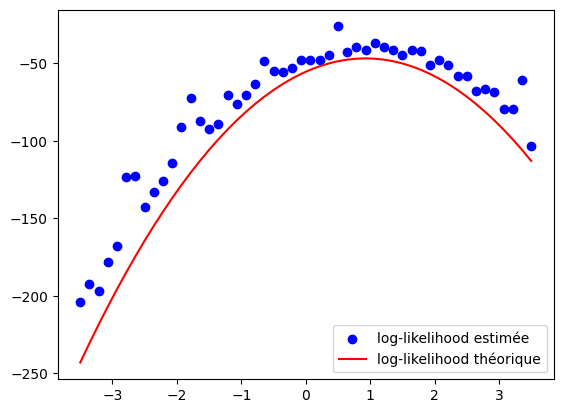

In [ ]:
gaussian_experience()

# **3) FONCTION POUR RUSSIAN ROULETTE**

In [8]:
def delta(w, w_O, w_E, K): # le ième élement de delta renvoie la value de delta_i
  delta = []
  sum = 0
  for k in range(int(K)+1):
    wk = w[:2**k]
    wk.extend(w[2**int(K):2**int(K) + 2**k])
    value = np.log(np.mean(wk)) - 0.5*(np.log(np.mean(w_O[:2**k])) + np.log(np.mean(w_E[:2**k])))
    delta.append(value)
  return delta

In [9]:
def estimator_ML_RR(n_sim, x, mean, cov, A, b, r):
    rr = []

    for i in range(n_sim):

        sum_rr = 0

        K = np.random.geometric(r, 1)
        z, z_O, z_E = generation_z(A,b,K,cov,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K,mean,cov,x,z,z_O,z_E)

        w = [p[i]/q[i] for i in range(len(p))] 
        w_O = [p_O[i]/q_O[i] for i in range(len(p_O))] 
        w_E = [p_E[i]/q_E[i] for i in range(len(p_E))]
            
        I0 = np.mean(np.log(w))
        
        # we compute the values of P(K >= k)
        proba_value = [1]
        for i in range(1,int(K)+1):
          proba_value.append((1-r)**(i-1))

        value_somme = [delta(w, w_O, w_E, K)[i]/proba_value[i] for i in range(int(K)+1)]

        sum_rr = sum(value_somme)
            
        ml_ll_rr = I0 + sum_rr
        rr.append(ml_ll_rr)
        
    mean_value = np.mean(rr)
    std_error_value = np.std(rr) / np.sqrt(len(rr))

    return mean_value


In [10]:
def estimate_theta_RR(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')
            c+=1
            
            Y.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [11]:
def estimate_both_SS_RR(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y_SS = [] #values of the log-likelihoods SS
    Y_RR = [] #values of the log-likelihoods RR

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')

            c+=1
            Y_SS.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_RR.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)
    
    return X, Y_SS,Y_RR

In [ ]:
def gaussian_experience_full(debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR = estimate_both_SS_RR(x,debut,fin,n_sim,n_interval)
  plt.figure(1)
  plt.scatter(X,Y_SS,color = 'blue',label = 'log-likelihood estimée via SS')
  plt.scatter(X,Y_RR,color = 'green',label = 'log-likelihood estimée via RR')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'log-likelihood théorique')
  plt.xlabel('theta')
  plt.ylabel('log-likelihood')
  plt.legend()

true value of theta -0.78852425948745
25%
50%
75%


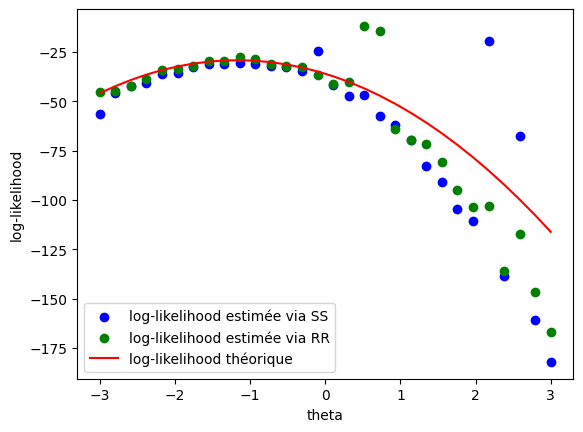

In [ ]:
gaussian_experience_full(debut = -3,fin = 3,n_sim = 500,n_interval = 30)

# **4) FONCTION IWAE**

In [12]:
def estimator_IWAE(n_sim, x, K0, mean_vect, covar, A, b):

    IWAE = []

    for i in range(n_sim):

        # generate our data following our true parameter theta_true and our observations at mean_vect
        sum = 0

        z, z_O, z_E = generation_z(A,b,K0,covar,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K0,mean_vect,covar,x,z,z_O,z_E)

        w = [p[i]/q[i] for i in range(len(p))]  
        sum = np.log(np.mean(w))   
        IWAE.append(sum)
    
    mean_value = np.mean(IWAE)
    std_error_value = np.std(IWAE) / np.sqrt(len(IWAE))

    return mean_value #the mean value of the log likelihood 

In [13]:
def estimate_theta_IWAE(x, K0,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')
            c+=1
            
            Y.append(estimator_IWAE(n_sim,x, K0, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20)))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [14]:
def estimate_theta_IWAE_without(x, K0,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    for k in liste:
            Y.append(estimator_IWAE(n_sim,x, K0, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20)))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [ ]:
def gaussian_experience_IWAE(K0, debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  theta_estimator, X, Y = estimate_theta_IWAE(x, K0 ,debut,fin,n_sim,n_interval)
  plt.scatter(X,Y,color = 'blue',label = 'log-likelihood estimated with IWAE')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'theoretical og-likelihood')
  plt.legend()


true value of theta -0.09950117544717184
25%
50%
75%


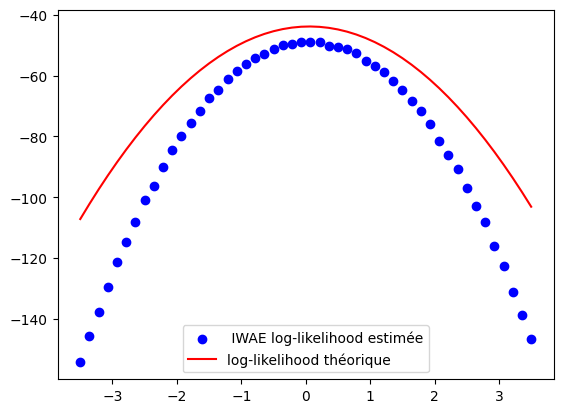

In [ ]:
gaussian_experience_IWAE(7)

# **5) COMPARAISON SS/RR/IWAE**

In [15]:
def gaussian_experience_full_2(K0,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR = estimate_both_SS_RR(x,debut,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE(x,K0,debut,fin,n_sim,n_interval)

  plt.axis([debut-0.3,fin+0.3,min(min(Y_SS),min(Y_RR),min(Y_IWAE))-50, 100])
  plt.scatter(X,Y_SS,color = 'blue',label = 'log-likelihood estimated with SS')
  plt.scatter(X,Y_RR,color = 'green',label = 'log-likelihood estimated with RR')
  plt.scatter(X_IWAE,Y_IWAE,marker = 'x',linewidth = 2.5,color = 'y',label = 'log-likelihood estimated with IWAE')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'theoretical log-likelihood')
  plt.axvline(x=theta_true, color='black', linestyle='--', label='theta_true='+ str('{:.3f}'.format(theta_true)))
  plt.xlabel('theta')
  plt.ylabel('log-likelihood')
  plt.legend()

  return Y_theorique, Y_SS, Y_RR, Y_IWAE

true value of theta -0.07923128565818358
25%
50%
75%
25%
50%
75%


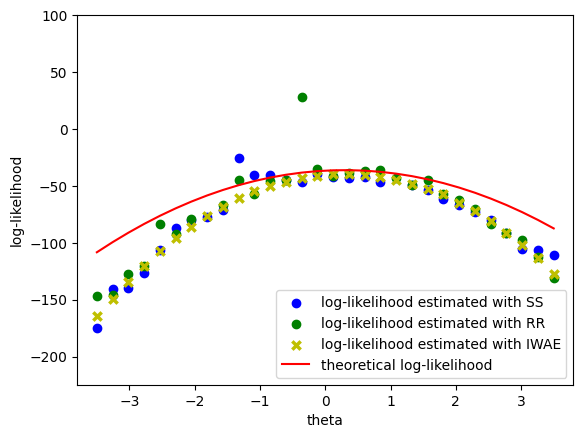

In [ ]:
gaussian_experience_full_2(4,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 30)

true value of theta -0.28845476913398277
25%
50%
75%
25%
50%
75%


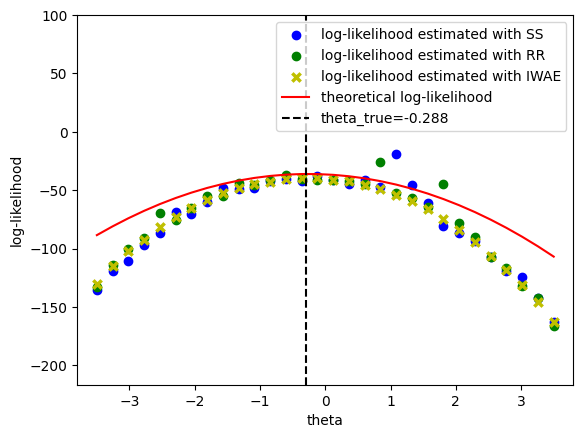

In [ ]:
Y_theorique, Y_SS, Y_RR, Y_IWAE = gaussian_experience_full_2(4,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 30)

# **6) FONCTION SUMO**

In [16]:
def delta_sumo(k, q, p):
    w_k2=[]
    w_k1=[]
    for i in range(k+1):
        w_k1.append(p[i]/q[i])
    for i in range(k+2):
        w_k2.append(p[i]/q[i])
    l_k1 = np.log(np.mean(w_k1))
    l_k2 = np.log(np.mean(w_k2))
    delta_sumo = l_k2-l_k1
    return delta_sumo

In [17]:
def sumo_estimator(n_sim, x, mean, cov, A, b, r):
    sumo = []
    for i in range(n_sim):
        sum_sumo = 0
        K = int(np.random.geometric(r))
        z, z_O, z_E = generation_z(A,b,K+2,cov,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K+2,mean,cov,x,z,z_O,z_E)
        w = np.log(p) - np.log(q)
            
        #third step : compute I0
        I0 = w.mean()
        
        for j in range(1,K):
            sum_sumo += (delta_sumo(j,q,p)/((1-r)**j))
            
        ml_ll_sumo = I0 + sum_sumo
        sumo.append(ml_ll_sumo)
        
    mean_value = np.mean(sumo)

    return mean_value

In [18]:
def estimate_both_SS_RR_SUMO(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y_SS = [] #values of the log-likelihoods SS
    Y_RR = [] #values of the log-likelihoods RR
    Y_SUMO = []

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')

            c+=1
            Y_SS.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_RR.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_SUMO.append(sumo_estimator(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    
    return X, Y_SS,Y_RR,Y_SUMO

In [ ]:
def gaussian_experience_full_3(K0,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR,Y_SUMO = estimate_both_SS_RR_SUMO(x,debut,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE(x,K0,debut,fin,n_sim,n_interval)

  plt.axis([debut-0.3,fin+0.3,min(min(Y_SS),min(Y_RR),min(Y_IWAE))-50, 75])
  plt.scatter(X,Y_SS,color = 'blue',label = 'log-likelihood estimated with SS')
  plt.scatter(X,Y_RR,color = 'green',label = 'log-likelihood estimated with RR')
  plt.scatter(X,Y_SUMO,marker = 'x',linewidth = 2.5,color = 'm', label = 'log-likelihood estimated with SUMO')
  plt.scatter(X_IWAE,Y_IWAE,marker = 'x',linewidth = 2.5,color = 'y',label = 'log-likelihood estimated with IWAE')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'theoretical log-likelihood')
  plt.axvline(x=theta_true, color='black', linestyle='--', label='theta_true='+ str('{:.3f}'.format(theta_true)))
  plt.xlabel('theta')
  plt.ylabel('log-likelihood')
  plt.legend()

  return Y_theorique, Y_SS, Y_RR,Y_SUMO,Y_IWAE

true value of theta -0.19623833068787722
25%
50%
75%
25%
50%
75%


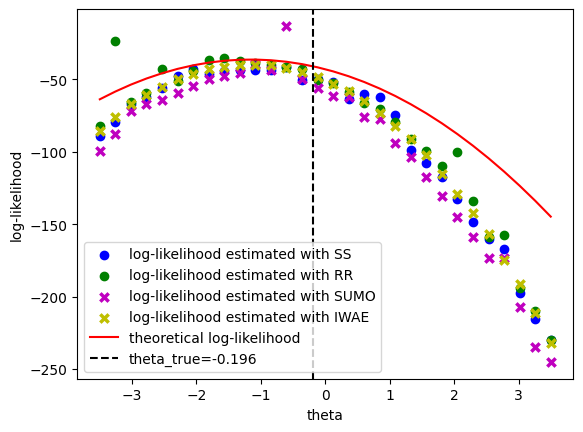

In [ ]:
Y_theorique, Y_SS, Y_RR,Y_SUMO, Y_IWAE = gaussian_experience_full_3(4,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 30)

true value of theta 0.8453469417555549
25%
50%
75%
25%
50%
75%


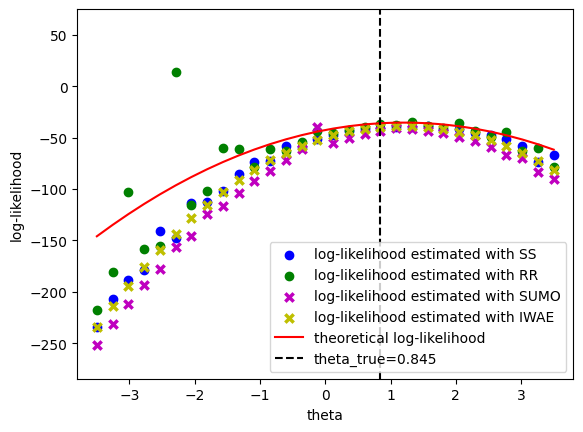

In [ ]:
Y_theorique, Y_SS, Y_RR,Y_SUMO, Y_IWAE = gaussian_experience_full_3(4,debut = -3.5,fin = 3.5,n_sim = 500,n_interval = 30)

# **7) BIAIS LOG-LIKELIHOOD**

In [19]:
def estimate_both_SS_RR_SUMO_without(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y_SS = [] #values of the log-likelihoods SS
    Y_RR = [] #values of the log-likelihoods RR
    Y_SUMO = []

    for k in liste:
            Y_SS.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_RR.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_SUMO.append(sumo_estimator(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)


    
    return X, Y_SS,Y_RR,Y_SUMO

In [20]:
def estimate_both_SS_RR_SUMO_without_theta(x,K0,theta_true, n_sim = 100):
    Y_theorique = [np.log(calcul_likelihood(x,theta_true))]
    Y_SS = estimator_ML_SS(n_sim,x, np.zeros(20)+ theta_true , np.identity(20), np.identity(20), np.zeros(20), 0.6)
    Y_RR = estimator_ML_RR(n_sim,x, np.zeros(20)+theta_true , np.identity(20), np.identity(20), np.zeros(20), 0.6)
    Y_SUMO = sumo_estimator(n_sim,x, np.zeros(20)+theta_true , np.identity(20), np.identity(20), np.zeros(20), 0.6)
    Y_IWAE = estimator_IWAE(n_sim,x, K0, np.zeros(20)+theta_true, np.identity(20), np.identity(20), np.zeros(20))
    return Y_theorique,Y_SS,Y_RR,Y_SUMO,Y_IWAE

In [ ]:
def full_bias(K0,start,end,number):
  theta_true = np.random.normal(0,1)
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  print(theta_true)
  Y_theorique = np.log(calcul_likelihood(x,theta_true))
  liste = np.linspace(start,end,number)
  biais_ss,biais_rr,biais_sumo,biais_iwae = [],[],[],[]
  for n in liste:
    print((n-start)*100/(end-start))
    biais_ss.append((estimator_ML_SS(int(n),x, np.zeros(20)+ theta_true , np.identity(20), np.identity(20), np.zeros(20), 0.6) - Y_theorique)**2)
    biais_rr.append((estimator_ML_RR(int(n),x, np.zeros(20)+theta_true , np.identity(20), np.identity(20), np.zeros(20), 0.6) - Y_theorique)**2)
    #biais_sumo.append((sumo_estimator(int(n),x, np.zeros(20)+theta_true , np.identity(20), np.identity(20), np.zeros(20), 0.6) - Y_theorique)**2)
    biais_iwae.append((estimator_IWAE(int(n),x, K0, np.zeros(20)+theta_true, np.identity(20), np.identity(20), np.zeros(20)) - Y_theorique)**2)
  plt.plot(liste,biais_ss, label = 'SS', c = 'blue')
  plt.plot(liste,biais_rr, label = 'RR', c = 'green')
  #plt.plot(liste,biais_sumo, label = 'SUMO', c = 'm')
  plt.plot(liste,biais_iwae, label = 'IWAE', c = 'y')
  #plt.axis([0,end+100,0,100])
  plt.title('Bias squared of the log-likelihood')
  plt.xlabel('number of simulations')
  plt.ylabel('mean bias squared of the log-likelihood')
  plt.legend()
  plt.show()

0.5106933461993202
0.0
11.11111111111111
22.22222222222222
33.333333333333336
44.44444444444444
55.55555555555556
66.66666666666667
77.77777777777777
88.88888888888889
100.0


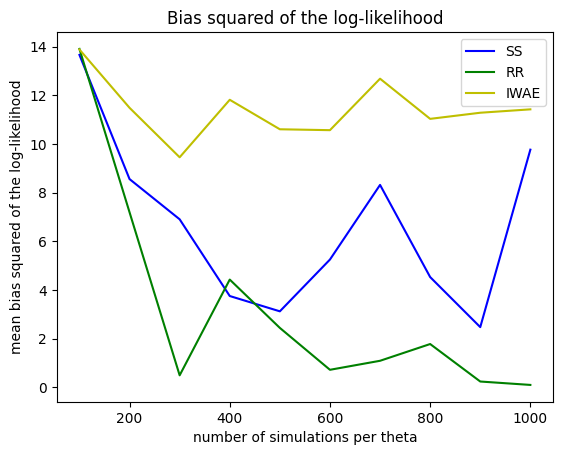

In [ ]:
full_bias(2,100,1000,10)

In [ ]:
def gaussian_experience_full_without(K0,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):
  theta_true = np.random.normal(0,1)
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR,Y_SUMO = estimate_both_SS_RR_SUMO_without(x,debut,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE_without(x,K0,debut,fin,n_sim,n_interval)
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]

  return Y_theorique, Y_SS, Y_RR,Y_SUMO, Y_IWAE

In [22]:
def compute_bias(Y_theorique, Y_SS, Y_RR, Y_SUMO, Y_IWAE):
  bias_ss = np.median([(Y_theorique[i]-Y_SS[i])**2 for i in range(len(Y_SS))])
  bias_rr = np.median([(Y_theorique[i]-Y_RR[i])**2 for i in range(len(Y_RR))])
  bias_sumo = np.median([(Y_theorique[i]-Y_SUMO[i])**2 for i in range(len(Y_SUMO))])
  bias_iwae = np.median([(Y_theorique[i]-Y_IWAE[i])**2 for i in range(len(Y_IWAE))])
  return bias_ss, bias_rr, bias_sumo, bias_iwae

In [21]:
def estimator_var(kind, K0, n_sim, x, mean_vect, covar, A, b, r):

    estim = []

    for i in range(n_sim):
        # generate our data following our true parameter theta_true and our observations at mean_vect
        K = np.random.geometric(r)

        z, z_O, z_E = generation_z(A,b,K,covar,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K,mean_vect,covar,x,z,z_O,z_E)

        # compute the proposal "posterior"
        w = [p[i]/q[i] for i in range(len(p))] 
        w_O = [p_O[i]/q_O[i] for i in range(len(p_O))] 
        w_E = [p_E[i]/q_E[i] for i in range(len(p_E))] 
        
        if kind == 'SS':
          I0 = np.mean(np.log(w))
          lO = np.log(np.mean(w_O))
          lE = np.log(np.mean(w_E))  
          L_OE = np.log(np.mean(w))
          delta_K = L_OE - 0.5*(lO + lE)
          proba = r*(1-r)**(int(K)-1)
          ML_SS = I0 + delta_K/proba
          estim.append(ML_SS)

        elif kind == 'RR':
          I0 = np.mean(np.log(w))
          proba_value = [1]
          for i in range(1,int(K)+1):
            proba_value.append((1-r)**(i-1))
          value_somme = [delta(w, w_O, w_E, K)[i]/proba_value[i] for i in range(int(K)+1)]
          sum_rr = sum(value_somme)
          ml_ll_rr = I0 + sum_rr
          estim.append(ml_ll_rr)

        elif kind == 'IWAE':
          z, z_O, z_E = generation_z(A,b,K0,covar,x)
          q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K0,mean_vect,covar,x,z,z_O,z_E)
          w = [p[i]/q[i] for i in range(len(p))]  
          sum_2 = np.log(np.mean(w))   
          estim.append(sum_2)
        
        elif kind == 'SUMO':
          sum_sumo = 0
          z, z_O, z_E = generation_z(A,b,K+2,covar,x)
          q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K+2,mean_vect,covar,x,z,z_O,z_E)
          w = np.log(p) - np.log(q)
          I0 = w.mean()
          for j in range(1,K):
              sum_sumo += (delta_sumo(j,q,p)/((1-r)**j)) 
          ml_ll_sumo = I0 + sum_sumo
          estim.append(ml_ll_sumo)
    

    return np.std(estim) / np.sqrt(len(estim)) 

In [23]:
def full_var_2(K0,start,end,number):
  theta_true = np.random.normal(0,1)
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  print(theta_true)
  liste = np.linspace(start,end,number)
  var_ss,var_rr,var_sumo,var_iwae = [],[],[],[]
  for n in liste:
    print((n-start)*100/(end-start))
    var_ss.append(estimator_var('SS', K0, int(n), x, np.zeros(20)+theta_true, np.identity(20), np.identity(20),  np.zeros(20), 0.6))
    var_rr.append(estimator_var('RR', K0, int(n), x, np.zeros(20)+theta_true, np.identity(20), np.identity(20),  np.zeros(20), 0.6))
    var_sumo.append(estimator_var('SUMO', K0, int(n), x, np.zeros(20)+theta_true, np.identity(20), np.identity(20),  np.zeros(20), 0.6))
    var_iwae.append(estimator_var('IWAE', K0, int(n), x, np.zeros(20)+theta_true, np.identity(20), np.identity(20),  np.zeros(20), 0.6))
  plt.plot(liste,var_ss, label = 'SS', c = 'blue')
  plt.plot(liste,var_rr, label = 'RR', c = 'green')
  plt.plot(liste,var_sumo, label = 'SUMO', c = 'm')
  plt.plot(liste,var_iwae, label = 'IWAE', c = 'y')
  plt.title('Standard errors of the estimated log-likelihoods')
  plt.xlabel('number of simulations')
  plt.ylabel('Standard errors of the log-likelihood')
  plt.legend()
  plt.show()

-0.5315218557258286
0.0
16.66666666666667
33.333333333333336
50.0
66.66666666666667
83.33333333333334
100.0


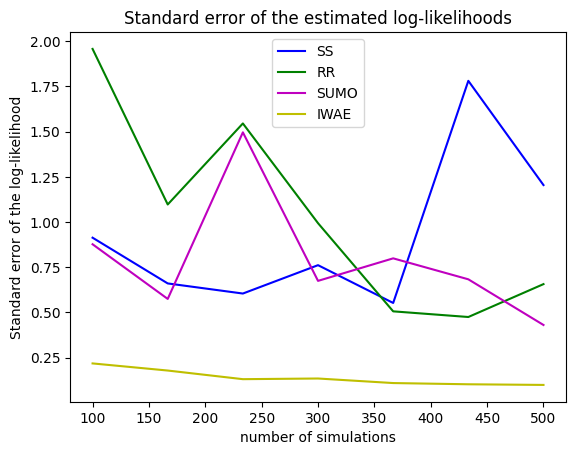

In [ ]:
full_var_2(3,100,500,7)

# **8) GRADIENT** 

In [24]:
def gradient_theo(x,theta):
  return 10*(np.mean(x)-theta)

In [62]:
def gaussian_experience_full_4(K0,debut = -3.5, fin = 3.5, n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR,Y_SUMO = estimate_both_SS_RR_SUMO(x,debut ,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE(x,K0,debut,fin ,n_sim,n_interval)

  plt.scatter(X,np.gradient(Y_SS),color = 'blue',label = 'gradient estimated with SS')
  plt.scatter(X,np.gradient(Y_RR),color = 'green',label = 'gradient estimated with RR')
  plt.scatter(X,np.gradient(Y_SUMO),marker = 'x',linewidth = 2.5,color = 'm', label = 'gradient estimated with SUMO')
  plt.scatter(X_IWAE,np.gradient(Y_IWAE),marker = 'x',linewidth = 2.5,color = 'y',label = 'gradient estimated with IWAE')
  Y_theorique = [gradient_theo(x,i) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'theoretical gradient')
  plt.axhline(y=0, color='black', linestyle=':',linewidth = 1, label=' gradient = 0')
  plt.axvline(x=theta_true, color='black', linestyle='--', linewidth = 1, label='theta_true='+ str('{:.3f}'.format(theta_true)))
  plt.xlabel('theta')
  plt.ylabel('gradient')
  plt.legend(bbox_to_anchor = [1,0.42])

  return Y_theorique, np.gradient(Y_SS), np.gradient(Y_RR), np.gradient(Y_SUMO), np.gradient(Y_IWAE)

true value of theta -0.25362655410859797
25%
50%
75%
25%
50%
75%


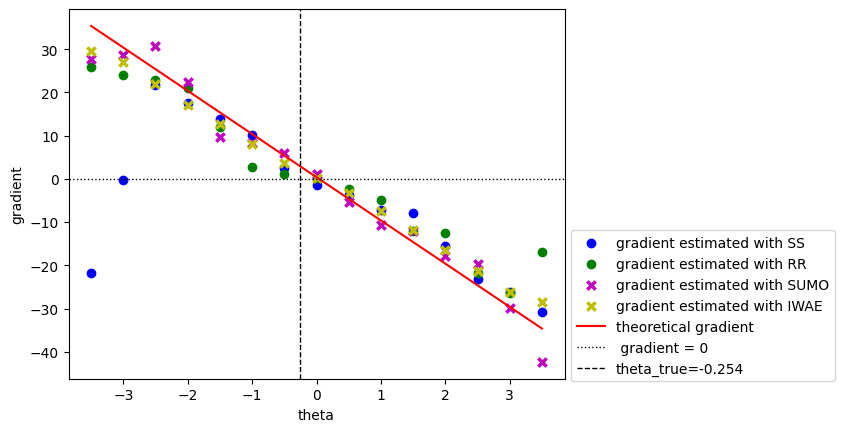

In [ ]:
Y_theorique, Y_SS, Y_RR,Y_SUMO, Y_IWAE = gaussian_experience_full_4(4,n_sim = 200,n_interval = 15)

In [40]:
def gaussian_experience_full_4_without(K0,debut = -3.5, fin = 3.5, n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)
  #theta_true = np.random.multivariate_normal(np.zeros(20),np.identity(20))
  #print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR,Y_SUMO = estimate_both_SS_RR_SUMO(x,debut ,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE(x,K0,debut,fin ,n_sim,n_interval)

  #print("theta estimé =",theta_estimator)
  #plt.figure(figsize=(8,6))
  #plt.axis([debut-0.3,fin+0.3,min(min(Y_SS),min(Y_RR),min(Y_IWAE))-50, 75])
  #plt.scatter(X,np.gradient(Y_SS),color = 'blue',label = 'gradient estimated with SS')
  #plt.scatter(X,np.gradient(Y_RR),color = 'green',label = 'gradient estimated with RR')
  #plt.scatter(X,np.gradient(Y_SUMO),marker = 'x',linewidth = 2.5,color = 'm', label = 'gradient estimated with SUMO')
  #plt.scatter(X_IWAE,np.gradient(Y_IWAE),marker = 'x',linewidth = 2.5,color = 'y',label = 'gradient estimated with IWAE')
  Y_theorique = [gradient_theo(x,i) for i in X]
  #plt.plot(X,Y_theorique, color = 'red',label = 'theoretical gradient')
  #plt.axhline(y=0, color='black', linestyle=':',linewidth = 1, label=' gradient = 0')
  #plt.axvline(x=theta_true, color='black', linestyle='--', linewidth = 1, label='theta_true='+ str('{:.3f}'.format(theta_true)))
  #plt.xlabel('theta')
  #plt.ylabel('gradient')
  #plt.legend(bbox_to_anchor = [1,0.42])

  return Y_theorique, np.gradient(Y_SS), np.gradient(Y_RR), np.gradient(Y_SUMO), np.gradient(Y_IWAE)

In [1]:
def full_bias_grad_2(K0,start,end,number):
  theta_true = np.random.normal(0,1)
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  print(theta_true)
  grad_theo = gradient_theo(x,theta_true)
  liste = np.linspace(start,end,number)
  biais_ss,biais_rr,biais_sumo,biais_iwae = [],[],[],[]
  for n in liste:
    print((n-start)*100/(end-start))
    X,Y_SS,Y_RR,Y_SUMO = estimate_both_SS_RR_SUMO_without(x,theta_true-0.1,theta_true+0.1,int(n),3)
    esti,X_IWAE, Y_IWAE = estimate_theta_IWAE_without(x,K0,theta_true-0.1,theta_true+0.1,int(n),3)
    #Y_theorique = [gradient_theo(x,i) for i in X]
    grad_ss,grad_rr,grad_sumo,grad_iwae = np.gradient(Y_SS)[1], np.gradient(Y_RR)[1], np.gradient(Y_SUMO)[1], np.gradient(Y_IWAE)[1]
    bias_ss_0, bias_rr_0, bias_sumo_0, bias_iwae_0 = (grad_ss - grad_theo)**2,(grad_rr - grad_theo)**2,(grad_sumo - grad_theo)**2,(grad_iwae - grad_theo)**2
    biais_ss.append(bias_ss_0)
    biais_rr.append(bias_rr_0)
    biais_sumo.append(bias_sumo_0)
    biais_iwae.append(bias_iwae_0)
  plt.plot(liste,biais_ss, label = 'SS', c = 'blue')
  plt.plot(liste,biais_rr, label = 'RR', c = 'green')
  plt.plot(liste,biais_sumo, label = 'SUMO', c = 'm')
  plt.plot(liste,biais_iwae, label = 'IWAE', c = 'y')
  plt.title('Bias squared of the log-likelihood gradient')
  plt.xlabel('number of simulations')
  plt.ylabel('mean bias squared of the log-likelihood gradient')
  plt.legend()
  plt.show()

-0.9086999335737165
0.0
25%
50%
75%
25%
50%
75%
25.0
25%
50%
75%
25%
50%
75%
50.0
25%
50%
75%
25%
50%
75%
75.0
25%
50%
75%
25%
50%
75%
100.0
25%
50%
75%
25%
50%
75%


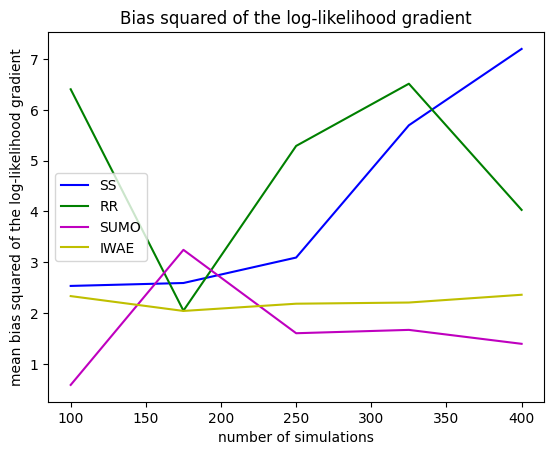

In [ ]:
full_bias_grad_2(2,100,400,5)

In [36]:
def full_var_grad(K0,start,end,number,nbre_iterations):
  theta_true = np.random.normal(0,1)
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  print(theta_true)
  liste = np.linspace(start,end,number)
  var_ss,var_rr,var_sumo,var_iwae = [],[],[],[]
  for n in liste:
    print((n-start)*100/(end-start))
    estim_ss,estim_rr,estim_sumo,estim_iwae = [],[],[],[]
    for i in range(nbre_iterations):
        X,Y_SS,Y_RR,Y_SUMO = estimate_both_SS_RR_SUMO_without(x,theta_true-0.1,theta_true+0.1,int(n),3)
        esti,X_IWAE, Y_IWAE = estimate_theta_IWAE_without(x,K0,theta_true-0.1,theta_true+0.1,int(n),3)
        grad_ss,grad_rr,grad_sumo,grad_iwae = np.gradient(Y_SS)[1], np.gradient(Y_RR)[1], np.gradient(Y_SUMO)[1], np.gradient(Y_IWAE)[1]
        estim_ss.append(grad_ss)
        estim_rr.append(grad_rr)
        estim_sumo.append(grad_sumo)
        estim_iwae.append(grad_iwae)
    var_ss.append(np.std(estim_ss)/np.sqrt(len(estim_ss)))
    var_rr.append(np.std(estim_rr)/np.sqrt(len(estim_rr)))
    var_sumo.append(np.std(estim_sumo)/np.sqrt(len(estim_sumo)))
    var_iwae.append(np.std(estim_iwae)/np.sqrt(len(estim_iwae)))
  plt.plot(liste,var_ss, label = 'SS', c = 'b')
  plt.plot(liste,var_rr, label = 'RR', c = 'g')
  plt.plot(liste,var_sumo, label = 'SUMO', c = 'purple')
  plt.plot(liste,var_iwae, label = 'IWAE', c = 'y')
  plt.title('Standard errors of the gradient')
  plt.xlabel('Number of simulations')
  plt.ylabel('Standard errors of the gradient')
  plt.legend()
  plt.show()

-0.8721152630966319
0.0
25.0
50.0
75.0
100.0


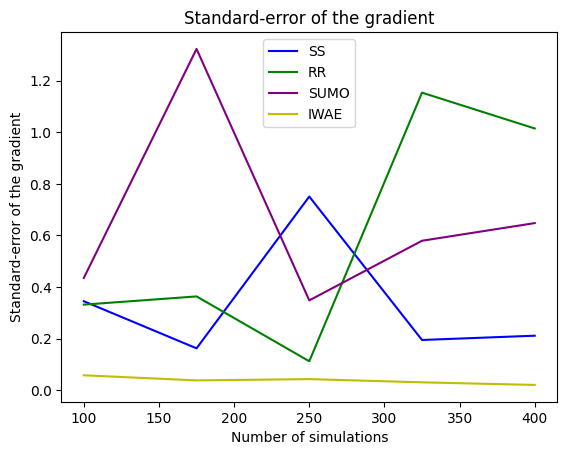

In [ ]:
full_var_grad(2,100,400,5,5)

# **9) GRADIENT DESCENT**

In [45]:
def get_nearest_index(array, x):
    diff = np.abs(array - x)
    nearest_index = np.argmin(diff)
    return nearest_index

In [80]:
def sgd(theta_array,grad,learning_rate,num_iterations):
  estim = 0
  for i in range(num_iterations):
    proche = get_nearest_index(theta_array,estim)
    gradi = grad[proche]
    estim += learning_rate*gradi
  return estim             

true value of theta -1.2605371267211811
25%
50%
75%
25%
50%
75%


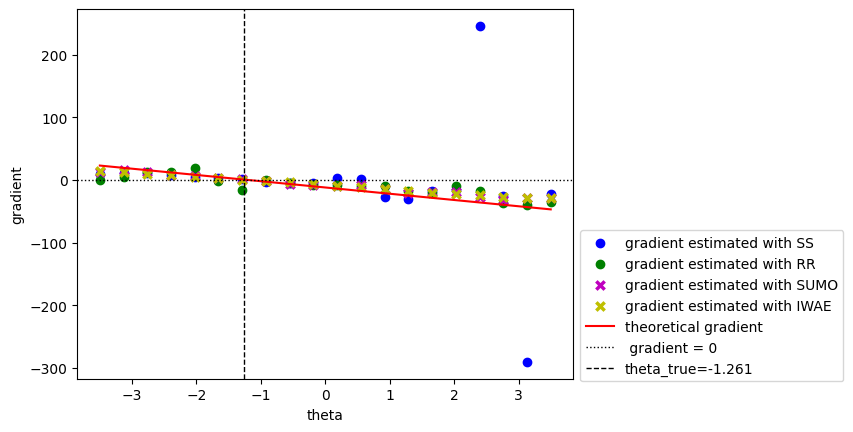

In [79]:
Y_theorique, grad_SS, grad_RR, grad_SUMO, grad_IWAE = gaussian_experience_full_4(2,debut = -3.5, fin = 3.5, n_sim = 300,n_interval = 20)

In [81]:
X = np.linspace(-3.5,3.5,20)

In [85]:
sgd(X,grad_SS,0.001,1000),sgd(X,grad_RR,0.001,1000),sgd(X,grad_SUMO,0.001,1000),sgd(X,grad_IWAE,0.001,1000),sgd(X,Y_theorique,0.001,1000)

(0.7150868642893575,
 -1.8371415733841523,
 -1.1038456834697519,
 -1.1055486080142731,
 -1.1078727010069378)

In [ ]:
#sgd biaisée à cause de notre découpage du segment [-3.5,3.5], on ne peut pas se rapprocher plus du theta_true

In [90]:
[[X[i],Y_theorique[i]] for i in range(len(X))] 

[[-3.5, 23.11212729899313],
 [-3.1315789473684212, 19.427916772677342],
 [-2.763157894736842, 15.743706246361548],
 [-2.3947368421052633, 12.05949572004576],
 [-2.026315789473684, 8.375285193729969],
 [-1.6578947368421053, 4.691074667414181],
 [-1.2894736842105265, 1.0068641410983936],
 [-0.9210526315789473, -2.6773463852173984],
 [-0.5526315789473686, -6.361556911533186],
 [-0.18421052631578982, -10.045767437848973],
 [0.18421052631578938, -13.729977964164766],
 [0.5526315789473681, -17.414188490480555],
 [0.9210526315789469, -21.098399016796343],
 [1.2894736842105257, -24.78260954311213],
 [1.6578947368421053, -28.466820069427925],
 [2.026315789473684, -32.15103059574371],
 [2.394736842105263, -35.8352411220595],
 [2.7631578947368416, -39.51945164837529],
 [3.1315789473684204, -43.203662174691075],
 [3.5, -46.88787270100687]]